### **Multi-Layer Perceptron (MLP) Neural Network**

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# LOAD PROCESSED DATA
df = pd.read_csv("processed_drug_consumption.csv")
# Specify input & target columns
target_cols = [
    'dissociatives', 'cannabinoids', 'empathogens',
    'depressants_pca', 'opioids_pca', 'stimulants_pca', 'psychedelics_pca', 'inhalants_pca'
]
input_cols = [col for col in df.columns if col not in target_cols] # there're FAR more input columns after one-hot encoding nominal variables

X = df[input_cols].values.astype('float32')
y = df[target_cols].values.astype('float32')

#### **Prepare Data for PyTorch**

In [3]:
# TRANSFORM DATA FOR PYTORCH

# Convert numpy representation of dataframes into compatible, multi-dimensional arrays (which can run on either CPU or GPU!)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

In [4]:
# CREATE PYTORCH DATALOADER

# Make PyTorch TensorDataset to be passed to the DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
# Specify train/test dataset sizes (80/20 split), and split the dataset into two aforementioned datasets
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, lengths=[train_size, test_size])

# Create PyTorch DataLoaders to "simplify loading and iterating over datasets while training deep learning models" https://www.geeksforgeeks.org/deep-learning/pytorch-dataloader/ 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Add shuffling to training data to prevent model from "memorizing" data order and finding unreliable/dubious patterns (not needed when testing)
test_loader = DataLoader(test_dataset, batch_size=32) # 32 is common batch size for smaller datasets

#### **Build/Configure Model**

In [5]:
# BUILD MLP MODEL

class MLP(nn.Module):
    # Model initialization with number of input/output features and (opt.) number of neurons in the hidden layers
    def __init__(self, input_size, output_size, hidden_neurons=64):
        super().__init__() # initializes parent class
        # Make the fully-connected/dense layers (having only one layer would make a linear model)
        self.fc1 = nn.Linear(input_size, hidden_neurons) # Input
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, output_size) # Output
    # Setup forward passing (data flow through the network)
    def forward(self, x):
        # Pass through the layers and apply ReLU activation (popular activation function, also add "non-linearity") after hidden layers (where app.) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = MLP(input_size=X.shape[1], output_size=y.shape[1])

In [6]:
# SETUP LOSS FUNCTION & OPTIMIZER

# Setup optimizer (Adam is commonly used, it adapts learning rate per parameter from model.parameters())
optimizer = torch.optim.Adam(model.parameters())
# Use Mean Squared Error for the loss function (default for most regression problems)
criterion = nn.MSELoss()

#### **Cross-Validation:** Training & Evalution

In [7]:
# CROSS VALIDATION

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
batch_size = 32
epochs = 50

fold_results = []
all_shap_values = []
all_val_X = []
# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/{num_folds}")
    # Prepare PyTorch datasets & dataloaders
    train_dataset = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
    val_dataset = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    #Initialize model, optimize, and loss
    model = MLP(input_size=X.shape[1], output_size=y.shape[1])
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    
    # Train Model
    for epoch in range(epochs):
        # Sets model in training mode and create accumulator for epoch's total loss 
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() # Reset gradient values (prevent unwanted accumulation)
            predictions = model(batch_X) # Forward pass to get predictions
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step() # Update weights w/ Adam (optimizer algorithm)

    # Evaluate Model
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader: 
            preds = model(batch_X)
            all_preds.append(preds.numpy())
            all_targets.append(batch_y.numpy())
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    # Calculate RMSE for each output (drug group)
    rmse_per_target = np.sqrt(np.mean((all_preds - all_targets) ** 2, axis=0))
    for col, rmse in zip(target_cols, rmse_per_target):
        print(f"Test RMSE for {col}: {rmse:.4f}")
    mean_rmse = np.mean(rmse_per_target)
    fold_results.append(mean_rmse)
# Print overall statistics    
print("\nCross-Validation RMSEs:", fold_results)
print("Mean RMSE:", np.mean(fold_results))
print("Stddev RMSE:", np.std(fold_results))

Fold 1/5
Test RMSE for dissociatives: 0.9871
Test RMSE for cannabinoids: 0.7970
Test RMSE for empathogens: 0.9070
Test RMSE for depressants_pca: 1.0222
Test RMSE for opioids_pca: 0.9084
Test RMSE for stimulants_pca: 0.9413
Test RMSE for psychedelics_pca: 0.7793
Test RMSE for inhalants_pca: 1.2899
Fold 2/5
Test RMSE for dissociatives: 1.0367
Test RMSE for cannabinoids: 0.8287
Test RMSE for empathogens: 1.0195
Test RMSE for depressants_pca: 1.0213
Test RMSE for opioids_pca: 1.0200
Test RMSE for stimulants_pca: 0.9439
Test RMSE for psychedelics_pca: 0.8865
Test RMSE for inhalants_pca: 1.0859
Fold 3/5
Test RMSE for dissociatives: 0.9739
Test RMSE for cannabinoids: 0.7877
Test RMSE for empathogens: 0.9664
Test RMSE for depressants_pca: 0.9786
Test RMSE for opioids_pca: 0.9639
Test RMSE for stimulants_pca: 0.9745
Test RMSE for psychedelics_pca: 1.0270
Test RMSE for inhalants_pca: 1.1860
Fold 4/5
Test RMSE for dissociatives: 1.0284
Test RMSE for cannabinoids: 0.8599
Test RMSE for empathogens:

#### **Save Model**

In [8]:
# torch.save(model, "model.pth")
# print("Model saved!")

#### **Evaluation:** Performance across Drug Groups

In [9]:
# Select a small subset as background for SHAP (e.g., 100 samples)
background = X_tensor[:100]

# Select up to 500 test samples to explain
test_sample = X_tensor[:500]

# Use DeepExplainer for PyTorch MLP
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_sample, check_additivity=False)

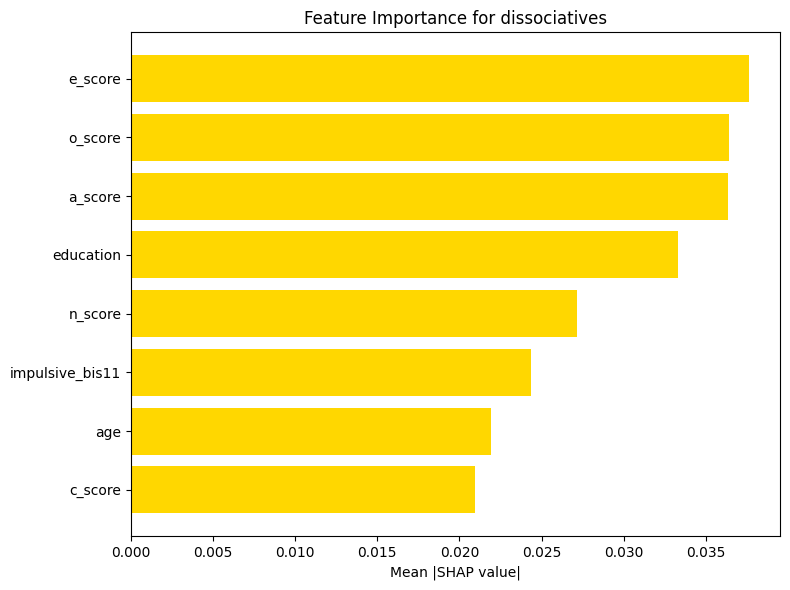

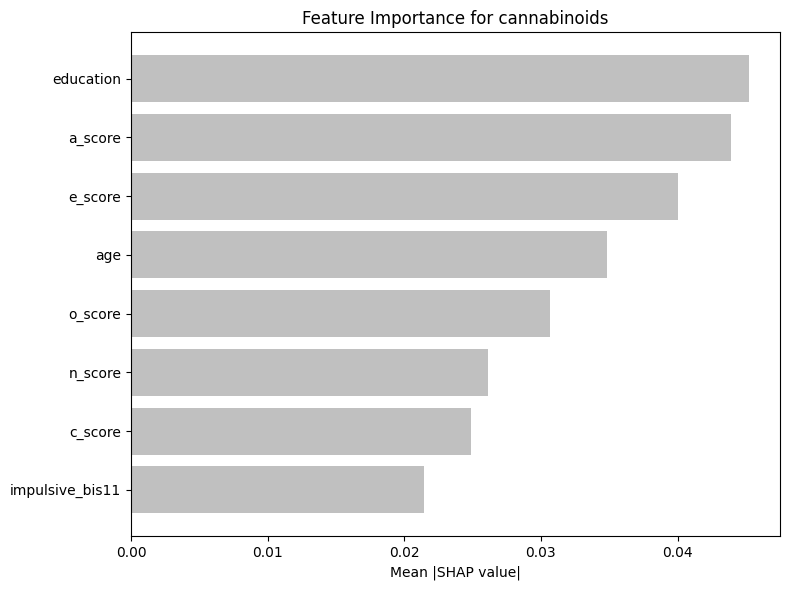

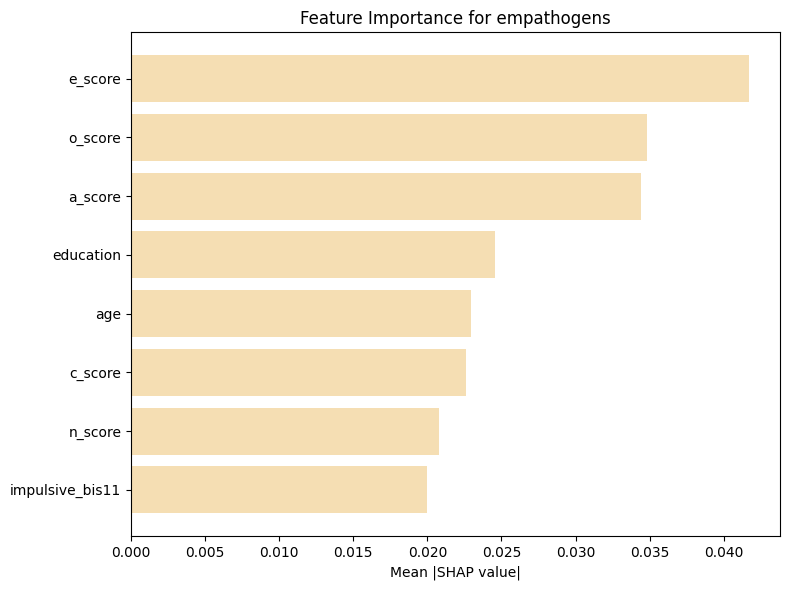

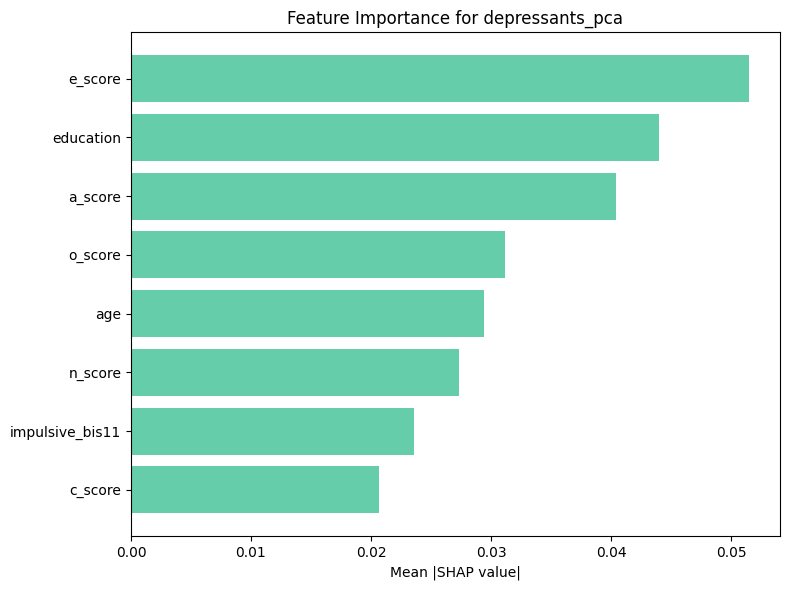

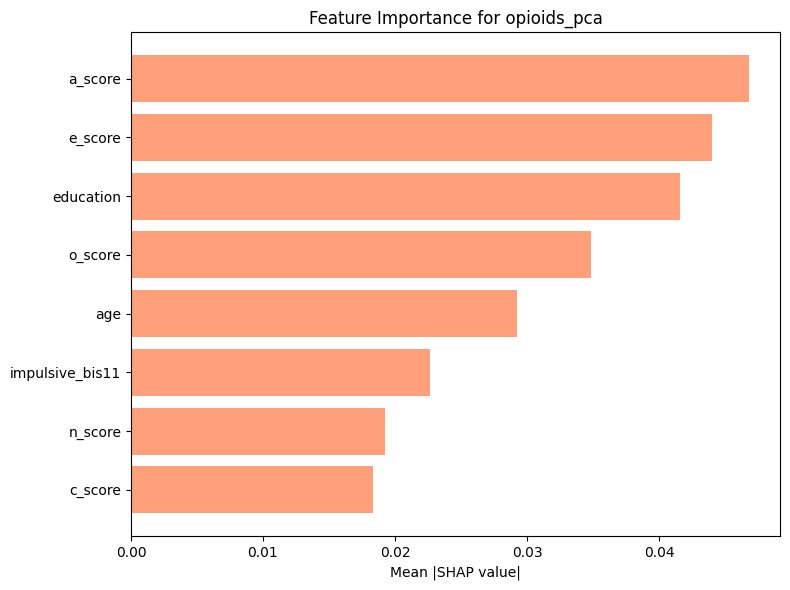

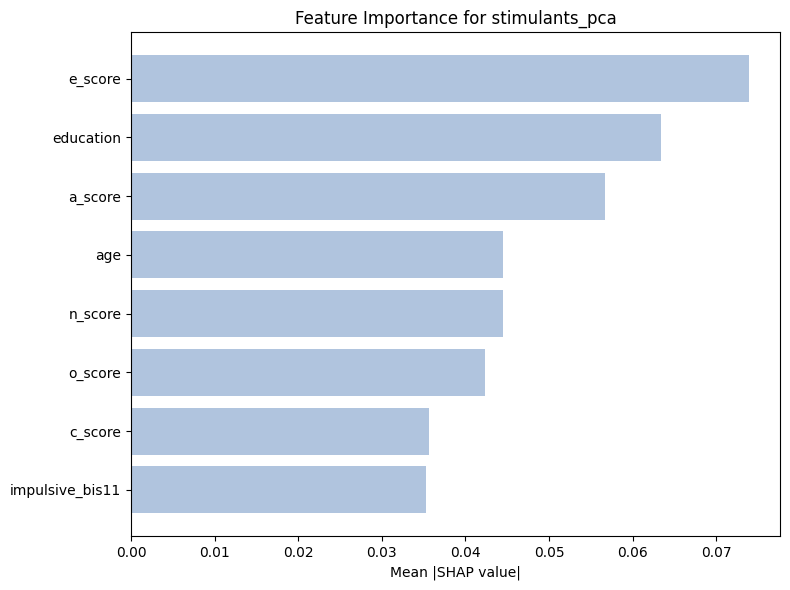

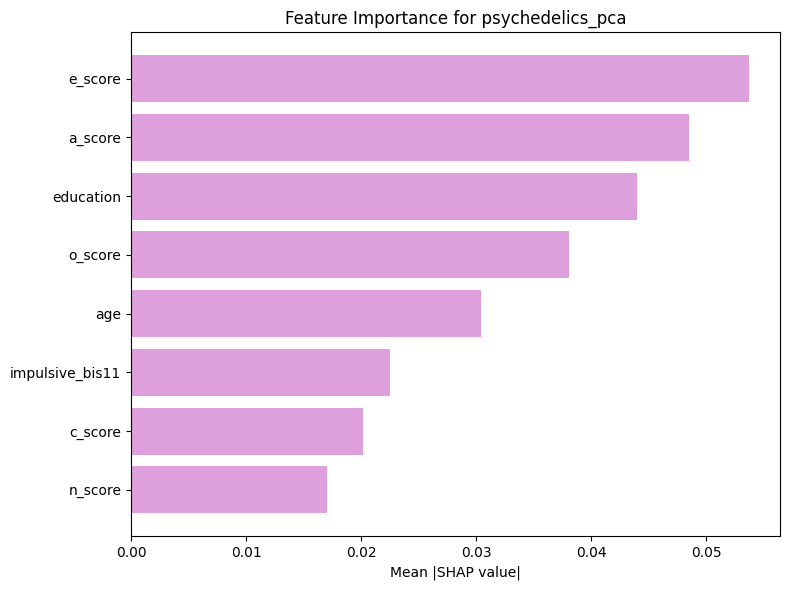

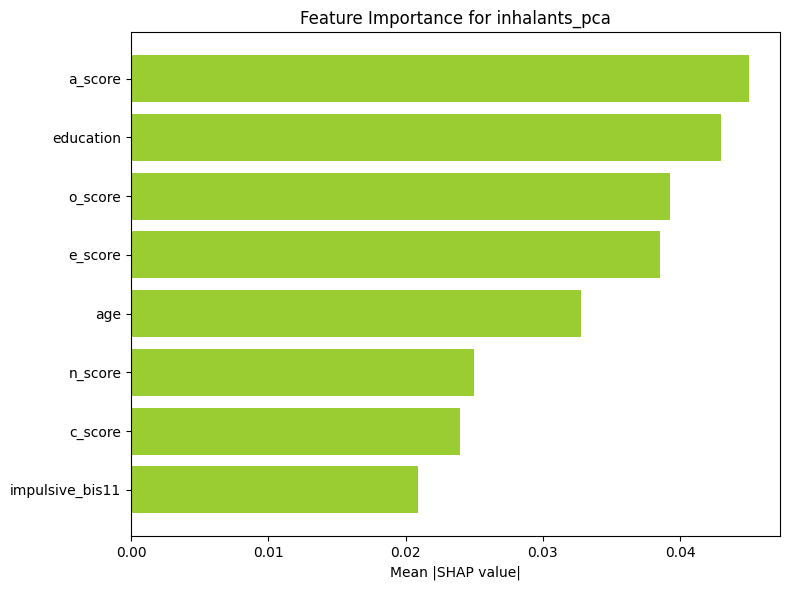

In [10]:
# Feature names (input columns)
feature_names = input_cols
colors = ["gold", "silver", "wheat", "mediumaquamarine", "lightsalmon", "lightsteelblue", "plum", "yellowgreen"]
# For each target (drug group)
for i, drug_group in enumerate(target_cols):
    # Compute mean absolute SHAP values for each feature
    shap_abs = np.abs(shap_values[i]).mean(axis=0)
    # Sort features by importance
    sorted_idx = np.argsort(shap_abs)[::-1]
    
    # Plot top 15 features
    plt.figure(figsize=(8, 6))
    plt.barh(
        [feature_names[j] for j in sorted_idx[:15]][::-1],
        shap_abs[sorted_idx[:15]][::-1],
        color=colors[i]
    )
    plt.xlabel('Mean |SHAP value|')
    plt.title(f'Feature Importance for {drug_group}')
    plt.tight_layout()
    plt.show()